The slides I'm using are available from the CMS wiki - http://climate-cms.wikis.unsw.edu.au/Training

I'm using the `conda/analysis3-unstable` environment for this demo, you can load it on Raijin/VDI with
```bash
module use /g/data3/hh5/public/modules
module load conda/analysis3-unstable
```

To start off with let's load some libraries

In [1]:
%matplotlib inline
import xarray
import dask
import bottleneck
import numpy

import dask.diagnostics
dask.diagnostics.ProgressBar().register()

The demo will be calculating heatwave thresholds from our ERA 5 replica data. CMS maintain replicas of many useful datasets at NCI so you don't have to download them yourself - http://climate-cms.wikis.unsw.edu.au/Category:Dataset

Heatwave detection requires a threshold value for each grid cell at each day of the year. This threshold is 
* the 90th percentile at each day of the year
* of a 15-day rolling mean
* of the daily maximum temperature

Hopefully you can take some of the techniques used here for your own analyses of large datasets

Our local archives have hourly fields at 0.25 x 0.25 degree resolution. For the single-level MX2T variable that's 408 GB of data, split across 467 files.

In [2]:
ds = xarray.open_mfdataset('/g/data/ub4/era5/netcdf/surface/MX2T/*/MX2T_era5_global_*.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 341057)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01T07:00:00 ... 2019-02-28T23:00:00
Data variables:
    mx2t       (time, latitude, longitude) float32 dask.array<shape=(341057, 721, 1440), chunksize=(737, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-03-11 22:11:16 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

This data goes from 1979/01/01 0700Z to 2019/02/28 2300Z. To make analysis simpler let's trim it so it starts at Jan 1 0000Z and ends at Dec 31 2300Z using a selector

In [21]:
ds = ds.sel(time = slice('19800101T0000Z', '20091231T2300'))

Since the data in the files is compressed, the in-memory size of this data is much bigger than the size on disk - a bit over one TB

In [4]:
mx2t = ds.mx2t

print(mx2t.nbytes / 1024 ** 3, 'GB')

1017.1860980987549 GB


Dask lets us work with data much larger than our computer's memory, because it only loads data when it's really needed - if we make a plot of a certain region it will only load that region's data

# Daily max temperature

Now to start our analysis - we have hourly max temperature, but want daily.

We could use resample, but this takes a long time

In [5]:
daily_max = mx2t.resample(time='D').max('time')
daily_max

<xarray.DataArray 'mx2t' (time: 10958, latitude: 721, longitude: 1440)>
dask.array<shape=(10958, 721, 1440), dtype=float32, chunksize=(1, 721, 1440)>
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2009-12-31
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

You can see that `chunksize=(1, 721, 1440)` - dask has created a new chunk for each individual day. With 10958 days to keep track of dask can get bogged down

A different way to go about this is by manipulating the shape of the array - we know since this is well-structured published data that there are always 24 values in each day's data

In [6]:
daily_time = mx2t.time.data.reshape((-1, 24))[:,0]
print(daily_time[0:4])

daily_max_data = mx2t.data.reshape((-1, 24, mx2t.shape[1], mx2t.shape[2])).mean(axis=1)
daily_max_data

['1980-01-01T00:00:00.000000000' '1980-01-02T00:00:00.000000000'
 '1980-01-03T00:00:00.000000000' '1980-01-04T00:00:00.000000000']


dask.array<mean_agg-aggregate, shape=(10958, 721, 1440), dtype=float32, chunksize=(31, 721, 1440)>

We've lost the xarray metadata, but you can see that the chunks are much bigger - we have a chunk for each month rather than each day

We can add metadata back by copying it from the original field

In [7]:
daily_max = xarray.DataArray(daily_max_data,
                             name = 'daily_max_t',
                             dims = mx2t.dims,
                             coords = {
                                 'time': ('time', daily_time),
                                 'latitude': mx2t.latitude,
                                 'longitude': mx2t.longitude,
                             })
daily_max

<xarray.DataArray 'daily_max_t' (time: 10958, latitude: 721, longitude: 1440)>
dask.array<shape=(10958, 721, 1440), dtype=float32, chunksize=(31, 721, 1440)>
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2009-12-31
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75

# 15-day rolling mean

Our next step is to do a rolling mean of the daily maximum

In [8]:
rolling = daily_max.rolling(time=15, center=True).mean()
rolling

<xarray.DataArray 'getitem-cee79fa3c2352a993a66c0dc8ded60c9' (time: 10958, latitude: 721, longitude: 1440)>
dask.array<shape=(10958, 721, 1440), dtype=float32, chunksize=(10958, 721, 1440)>
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2009-12-31
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75

This time we've the opposite problem - rather than having one chunk per day, we have one chunk for the entire 1 TB dataset!

This is due to a [bug](https://github.com/pydata/xarray/issues/2940) in Xarray. It's possible, although clunky, to do the rolling mean directly in dask and keep the original chunking

In [9]:
rolling_data = dask.array.overlap.map_overlap(
        daily_max.data,
        func=bottleneck.move_mean,
        window=15,
        axis=0,
        depth=(14,0,0),
        boundary='reflect',
        trim=True,
        dtype=daily_max.data.dtype)

rolling_data

dask.array<_trim, shape=(10958, 721, 1440), dtype=float32, chunksize=(31, 721, 1440)>

Note the rolling mean is not centred doing the calculation this way - it's the mean over this day and 14 previous days, rather than the mean of 7 days before, this day, 7 days after.

When we convert back to a DataArray we need to keep this time offset in mind

In [10]:
rolling_time = daily_max.time.data - numpy.timedelta64(7, 'D')

rolling = xarray.DataArray(rolling_data,
                             name = 'daily_max_t',
                             dims = daily_max.dims,
                             coords = {
                                 'time': ('time', rolling_time),
                                 'latitude': daily_max.latitude,
                                 'longitude': daily_max.longitude,
                             })

rolling

<xarray.DataArray 'daily_max_t' (time: 10958, latitude: 721, longitude: 1440)>
dask.array<shape=(10958, 721, 1440), dtype=float32, chunksize=(31, 721, 1440)>
Coordinates:
  * time       (time) datetime64[ns] 1979-12-25 1979-12-26 ... 2009-12-24
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75

At this point all of the time domain processing is done - we've calculated the 15 day rolling mean of the daily maximum temperature. It's a good idea to plot some data to make sure everything's looking reasonable

[########################################] | 100% Completed | 32.6s
[########################################] | 100% Completed | 29.2s


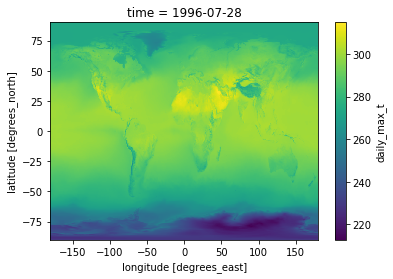

In [11]:
rolling.sel(time='19960728').plot()

# 90th Percentile by Day of Year

Now it's time to get the 90th percentile for each day in the year.

The simplest way to do this is
```python
rolling.groupby('time.dayofyear').reduce(numpy.percentile, dim='time', q=90)
```
however there are problems with our giant dataset:

* By default `.reduce()` is not Dask-aware - it loads all the data. This can be fixed by adding `allow_lazy=True` to the arguments
* `numpy.percentile` isn't Dask aware either, so we need to add Dask support to the existing function

`dask.map_blocks` allows us to make a Dask-aware version of `numpy.percentile` - it tells Dask to run a function on each chunk. Since `percentile` is a reduction operation we need to join up all of the chunks along the time axis first and add the `drop_axis` argument

In [12]:
def dask_percentile(array, axis, q):
    array = array.rechunk({axis: -1})
    return array.map_blocks(
        numpy.percentile,
        axis=axis,
        q=q,
        dtype=array.dtype,
        drop_axis=axis)

doy_p90 = (rolling
           .groupby('time.dayofyear')
           .reduce(dask_percentile, dim='time', q=90,
                   allow_lazy=True))
doy_p90

<xarray.DataArray 'daily_max_t' (dayofyear: 366, latitude: 721, longitude: 1440)>
dask.array<shape=(366, 721, 1440), dtype=float32, chunksize=(1, 721, 1440)>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

Now we're ready to try it out!

In [13]:
doy_p90.sel(dayofyear=39).plot()

[##############                          ] | 35% Completed |  5min 16.6s


RuntimeError: NetCDF: HDF error

It's working, but it takes much longer than we'd like for test purposes, and on VDI you're likely to run into HDF5 errors. Let's gather our progress up to now in a function so we can try some work-arounds

In [14]:
def rolling_maximum(dataset):
    daily_time = dataset.time.data.reshape((-1, 24))[:,0]
    daily_max_data = dataset.data.reshape((-1, 24, 
                                           dataset.shape[1], 
                                           dataset.shape[2])
                                         ).mean(axis=1)
    
    rolling_time = daily_time - numpy.timedelta64(7, 'D')
    rolling_data = dask.array.overlap.map_overlap(
        daily_max_data,
        func=bottleneck.move_mean,
        window=15,
        axis=0,
        depth=(14,0,0),
        boundary='reflect',
        trim=True,
        dtype=daily_max_data.dtype)
    
    rolling = xarray.DataArray(rolling_data,
                             dims = dataset.dims,
                             coords = {
                                 'time': ('time', rolling_time),
                                 'latitude': dataset.latitude,
                                 'longitude': dataset.longitude,
                             })
    
    return rolling

# Chunk sizes

Dask isn't the only thing that splits data into chunks. NetCDF4 files do it too (it helps with compression)

You can look at the `.encoding` attribute of a Xarray variable to see information about the file storage

In [17]:
ds.mx2t.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (93, 91, 180),
 'source': '/g/data/ub4/era5/netcdf/surface/MX2T/1979/MX2T_era5_global_19790101_19790131.nc',
 'original_shape': (737, 721, 1440),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.0016965627572058163,
 'add_offset': 265.9024415135433}

The size of chunks can have a huge effect on performance and memory use. You don't want them too big, as then you'll fill up your memory, and you don't want too many of them or Dask gets bogged down trying to keep track of everything.

Chunk sizes are set by the `chunks` argument to `open_dataset`. A good starting point is to use the chunk sizes from the file. If you're not doing much time processing it's good to try a small value for the time dimension too.

In [18]:
ds_c = xarray.open_mfdataset('/g/data/ub4/era5/netcdf/surface/MX2T/*/'
                             'MX2T_era5_global_*.nc',
                             chunks={'latitude': 91, 'longitude': 180})
mx2t_c = ds_c.mx2t

Another thing that can help for testing very large datasets is to just run the analysis on a small section of the full dataset - say we feed our analysis just a few years of the whole range, only over Australia

In [19]:
mx2t_aus = mx2t_c.sel(time = slice('19800101T0000Z', '19841231T2300'),
                      latitude=slice(0,-60),
                      longitude=slice(100,160))

rolling_c = rolling_maximum(mx2t_aus)

doy_p90_c = (rolling_c
             .groupby('time.dayofyear')
             .reduce(dask_percentile, dim='time', q=90,
                     allow_lazy=True))

[########################################] | 100% Completed |  1min  1.0s
[########################################] | 100% Completed | 29.5s


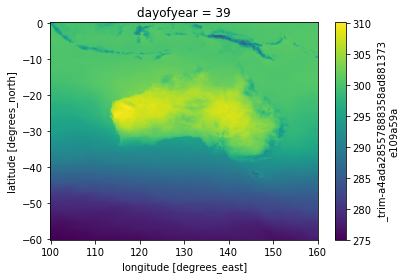

In [20]:
doy_p90_c.sel(dayofyear=39).plot()

A minute and a half is reasonable, though you may want to reduce the domain even further if you need to debug something

# Running on Raijin

With test jobs working interactively we can move on to doing the full analysis. This will take a bit of time and memory, so rather than the shared VDI nodes we'll make a script to run on Raijin.

When running on a compute node we want a bit more control over how Dask runs - for instance number of processors and memory limit

```python
import dask.distributed

if __name__ == '__main__':
    client = dask.distributed.Client(
        n_workers=8, threads_per_worker=1,
        memory_limit='4gb', local_dir=tempfile.mkdtemp())
```

Note that if you're using a client you must use a `if __name__ == '__main__'` guard around your script

```python
if __name__ == '__main__':
    client = dask.distributed.Client(
        n_workers=8, threads_per_worker=1,
        memory_limit='4gb', local_dir=tempfile.mkdtemp())

    ds = xarray.open_mfdataset('/g/data/ub4/era5/netcdf/surface/MX2T/*/'
                               'MX2T_era5_global_*.nc',
                               chunks={'latitude': 91})

    # Trim to full days, with a bit of a buffer for the rolling mean
    ds = ds.sel(time=slice('19791201','20100201'))

    # Perform the rolling mean of daily max and trim the output to the
    # target period
    rolled = rolling_maximum(ds.mx2t).sel(time=slice('19800101','20100101'))

    # Perform the percentile
    doy_p90 = (rolled.groupby('time.dayofyear')
                     .reduce(dask_percentile, dim='time', q=90,
                             allow_lazy=True))

    # Save to a file
    doy_p90 = doy_p90.to_dataset(name='mx2t_doy_p90')
    saver = doy_p90.to_netcdf('mx2t_doy_p90.nc', compute=False)
    
    # Add a progress bar
    future = client.persist(saver)
    dask.distributed.progress(future)
    future.compute()
```

```python
from dask.distributed import Client, progress
import tempfile
import xarray
import dask
import bottleneck
import numpy


def dask_percentile(array, axis, q):
    """
    Calculate numpy.percentile over an axis for a Dask array
    """
    array = array.rechunk({axis: -1})
    return array.map_blocks(numpy.percentile, axis=axis, q=q, dtype=array.dtype, drop_axis=axis)


def rolling_maximum(dataset):
    """
    Calculates a 15 day rolling mean of daily maximum temperatures
    
    Assumes 24 samples per day, time is the first dimension
    """
    daily_time = dataset.time.data.reshape((-1, 24))[:,0]
    daily_max_data = dataset.data.reshape((-1, 24, dataset.shape[1], dataset.shape[2])).mean(axis=1)

    rolling_time = daily_time - numpy.timedelta64(7, 'D')
    rolling_data = dask.array.overlap.map_overlap(
        daily_max_data,
        func=bottleneck.move_mean,
        window=15,
        axis=0,
        depth=(14,0,0),
        boundary='reflect',
        trim=True,
        dtype=daily_max_data.dtype)

    # Convert back to xarray
    rolling = xarray.DataArray(rolling_data,
                             dims = dataset.dims,
                             coords = {
                                 'time': ('time', rolling_time),
                                 'latitude': dataset.latitude,
                                 'longitude': dataset.longitude,
                             })

    return rolling


if __name__ == '__main__':
    c = Client(n_workers=8, threads_per_worker=1, memory_limit='4gb', local_dir=tempfile.mkdtemp())

    ds = xarray.open_mfdataset('/g/data/ub4/era5/netcdf/surface/MX2T/*/MX2T_era5_global_*.nc',
                               chunks={'latitude': 91*2, 'longitude': 180*2})

    ds = ds.sel(time=slice('19791201','20100201'))

    rolled = rolling_maximum(ds.mx2t).sel(time=slice('19800101','20010101'))

    doy_p90 = (rolled
                    .groupby('time.dayofyear')
                    .reduce(dask_percentile, dim='time', q=90, allow_lazy=True))

    doy_p90 = doy_p90.to_dataset(name='mx2t_doy_p90')

    progress(future)
```